# Adversarial Machine Learning: Data Poisoning and Model Extraction Attacks

## Security Analysis of Logistic Regression Classifier

This analysis demonstrates adversarial machine learning attacks against a logistic regression classifier. We evaluate three attack vectors: availability poisoning, targeted poisoning, and functional model extraction.

The dataset contains measurements for 3 plant species (Iris setosa, versicolor, and virginica). The model uses four features: sepal length, sepal width, petal length, and petal width.

In [1]:
# Import packages
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import copy




In [ ]:
# Load dataset
df = pd.read_csv("iris_extended.csv")

In [3]:
# Take a look at the data
print(df.head())
print(df.columns)
print(df.shape)

  species  elevation soil_type  sepal_length  sepal_width  petal_length  \
0  setosa      161.8     sandy          5.16         3.41          1.64   
1  setosa      291.4      clay          5.48         4.05          1.53   
2  setosa      144.3     sandy          5.10         2.80          1.47   
3  setosa      114.6      clay          4.64         3.44          1.53   
4  setosa      110.9     loamy          4.85         2.87          1.23   

   petal_width  sepal_area  petal_area  sepal_aspect_ratio  ...  \
0         0.26     17.5956      0.4264            1.513196  ...   
1         0.37     22.1940      0.5661            1.353086  ...   
2         0.38     14.2800      0.5586            1.821429  ...   
3         0.17     15.9616      0.2601            1.348837  ...   
4         0.26     13.9195      0.3198            1.689895  ...   

   sepal_to_petal_length_ratio  sepal_to_petal_width_ratio  \
0                     3.146341                   13.115385   
1                     

We separate the dataset into training and testing sets. The training data is used to train the model, and the testing data evaluates the model's performance on unseen production data.

In [ ]:
# Randomly split data into training and test/production sets
np.random.seed(1)
training_rows = np.random.choice(df.index, size=1000, replace=False)
test_rows = df.index.difference(training_rows)

train_df = df.loc[training_rows]
test_df = df.loc[test_rows]
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Feature distributions across species reveal class separability and inform attack strategy design.

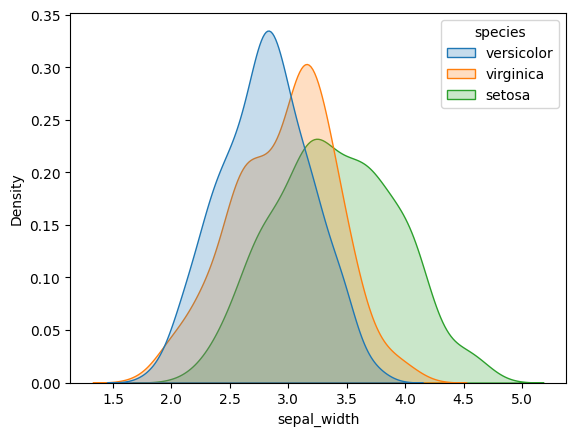

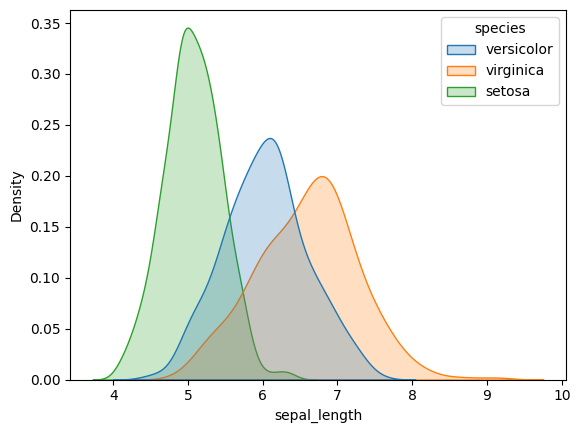

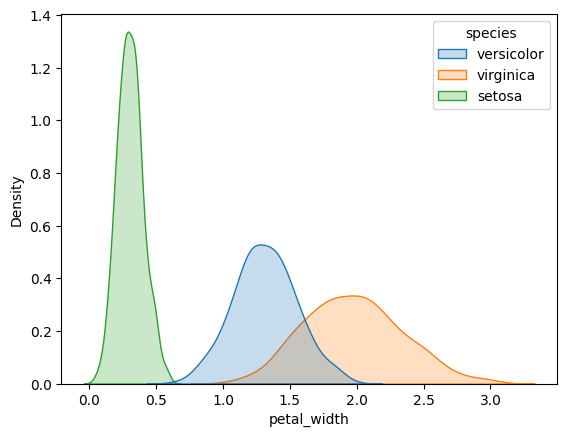

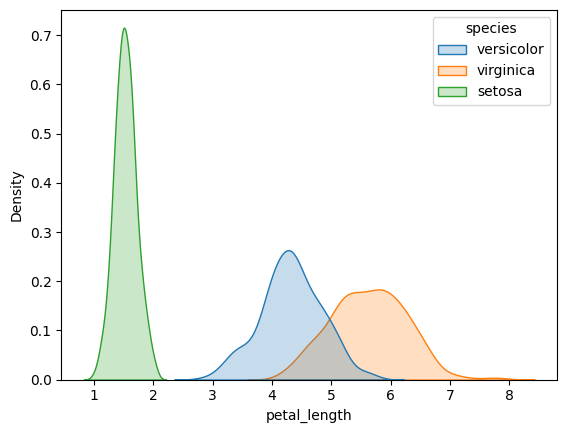

In [5]:
sns.kdeplot(data=train_df, x="sepal_width", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="sepal_length", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="petal_width", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="petal_length", hue="species", fill=True)
plt.show()

We train a logistic regression model on the training data to predict species using sepal length, sepal width, petal length, and petal width. This serves as our target model for adversarial evaluation.


In [6]:

features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]



def train_and_test_model(train_df, test_df, features):
    X_train = train_df[features]
    y_train = train_df["species"]
    X_test = test_df[features]
    y_test = test_df["species"]

    lr_model = sklearn.linear_model.LogisticRegression(random_state=1, max_iter=1000)
    lr_model.fit(X_train, y_train)

    accuracy_score = sklearn.metrics.accuracy_score(y_test, lr_model.predict(X_test))
    correct_predictions = (y_test == lr_model.predict(X_test))
    return accuracy_score, correct_predictions, lr_model


In [7]:
accuracy_score,_,_= train_and_test_model(train_df,test_df,features)
print("The accuracy of the model is: ",accuracy_score)

The accuracy of the model is:  0.93


Baseline model accuracy on clean training data: 93%.

# Availability Poisoning Attack

## Objective: Degrade model performance below operational threshold

We conduct a data poisoning attack by injecting adversarial samples into the training data to degrade model performance.

Attack methodology: inject chaff data into the training set rather than modifying existing samples. This simulates an adversary with append-only access to the training pipeline.

In [ ]:
import numpy as np
np.random.seed(1)

# Generate chaff samples near the setosa cluster but mislabeled as versicolor
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Calculate mean of the setosa class
setosa_mean = train_df.loc[train_df["species"] == "setosa", features].mean()
setosa_std = train_df[features].std()

# Number of chaff records to inject
# Attack effectiveness: 100 samples had minimal impact, 500 samples degrade accuracy below 75% threshold
n = 500

# Generate noisy data points around setosa's mean
poison_X = pd.DataFrame({
    col: setosa_mean[col] + 0.3 * setosa_std[col] * np.random.randn(n)
    for col in features
})

# Mislabel all fake samples as versicolor
poison_y = pd.Series(["versicolor"] * n, name="species")

# Combine into poisoned DataFrame
poisoning_data = pd.concat([poison_X, poison_y], axis=1)

In [ ]:
# Combine poisoned data with original training data
availability_poisoned_df = pd.concat([train_df, poisoning_data], ignore_index=True)

# Train model on poisoned dataset and evaluate on production data
accuracy_score,_,_ = train_and_test_model(train_df=availability_poisoned_df, test_df=test_df, features=features)
print("The accuracy of the model is: ",accuracy_score)

The accuracy of the model is:  0.645


**Attack success criteria**: Model accuracy degraded to 64.5%, below the 75% operational threshold. The attack successfully forces model retraining or deployment suspension. 

# Targeted Poisoning Attack

## Objective: Force misclassification of a specific sample

This attack targets a specific sample for misclassification without significantly degrading overall model accuracy. The goal is to evade detection while achieving the targeted outcome.

Target sample for evasion attack:

In [16]:
test_df.loc[0,features+["species"]]

sepal_length      4.48
sepal_width       3.31
petal_length       1.4
petal_width       0.27
species         setosa
Name: 0, dtype: object

Attack objective: force classification as 'virginica' by strategically poisoning the training data.

In [ ]:
# Create a copy of training data for targeted poisoning (preserve original)
targeted_poison_df = copy.deepcopy(train_df)

In [ ]:
# Targeted poisoning strategy: inject a tight cluster of mislabeled samples
# around the target point to locally shift the decision boundary
import numpy as np
np.random.seed(2)

# Extract target feature vector
x_star = test_df.loc[0, features]

# Use training dispersion to scale attack points
train_sd = train_df[features].std()

m = 100       # Number of attack points
spread = 0.03 # Tight clustering around target point

# Generate attack samples in tight cluster around target
attack_X = pd.DataFrame({
    col: x_star[col] + spread * train_sd[col] * np.random.randn(m)
    for col in features
})
attack_y = pd.Series(["virginica"] * m, name="species")

# Append mislabeled cluster to training data
targeted_poison_df = pd.concat(
    [targeted_poison_df, pd.concat([attack_X, attack_y], axis=1)],
    ignore_index=True
)


Training the model on the poisoned dataset and evaluating prediction on the target sample:

In [26]:
_,_,target_model = train_and_test_model(train_df=targeted_poison_df, test_df=test_df, features=features)
target_model.predict(test_df.loc[[0], features])

array(['virginica'], dtype=object)

# Functional Model Extraction Attack

## Objective: Extract model functionality via query-based replication

We construct a shadow model that replicates the target model's behavior by querying its predictions and training a surrogate classifier. The shadow model should produce similar predictions to the target model on unseen production data.

Query interface for the target model. Takes feature vectors as input and returns class predictions.


In [27]:
_,_,target_model = train_and_test_model(train_df=train_df, test_df=test_df, features=features)

def query(x):
    return target_model.predict(x)[0] 

We generate synthetic query samples and collect target model predictions. Samples are drawn from a distribution similar to the training data, simulating an adversary with access to a related but distinct dataset.

In [ ]:
# Generate synthetic query samples
import numpy as np
np.random.seed(3)

# Number of queries to send to target model
n = 2000

# Generate query samples from distribution similar to training data
X_queries = pd.DataFrame({
    "sepal_length": train_df['sepal_length'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "sepal_width": train_df['sepal_width'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "petal_length": train_df['petal_length'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "petal_width": train_df['petal_width'].mean()+train_df['sepal_length'].std()*np.random.randn(n)})

# Collect target model predictions for each query
class_predicted = pd.Series([query(X_queries.iloc[[i]]) for i in range(n)], name="species")



Training a surrogate model (Random Forest) on the query-response pairs to replicate target model behavior.

In [ ]:
# Train Random Forest surrogate model on query-response pairs
shadow_model = sklearn.ensemble.RandomForestClassifier(random_state=1)
shadow_model.fit(X_queries, class_predicted)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluation: comparing target model and shadow model predictions on production data (unseen by both models).

**Extraction success criteria**: Shadow model achieves >90% prediction agreement with target model.

In [30]:
def evaluate_shadow_model(clean_model, shadow_model, test_df):

    target_predictions = clean_model.predict(test_df[features])
    shadow_predictions = shadow_model.predict(test_df[features])
    print("The target and shadow models agree on: ",sklearn.metrics.accuracy_score(target_predictions,shadow_predictions)," percent of the samples")

evaluate_shadow_model(target_model, shadow_model, test_df)
    

The target and shadow models agree on:  0.965  percent of the samples
